**** *Disclaimer* ****

The process described in this notebook replicates the method outlined in the report, using a combination of random search and grid search for hyperparameter tuning. However, it is important to note the following:

- Differences in Computational Resources: The original experiments were conducted on the DTU's High-Performance Computing (HPC) cluster with extensive computational resources. This allowed for large-scale experiments with a broader search space and more iterations.

- Simplification for Demonstration: This notebook is designed to be executable by anyone on a local machine or modest computational resources. As such:

  - The data size and number of iterations for random and grid searches have been significantly reduced.
  - The results produced by this notebook will differ from the report because the scale of experimentation is smaller.
- Process Integrity: Despite these differences, the overall methodology remains consistent. The workflow, including random search followed by grid search on the refined parameter space, matches the approach used in the report.

By making these adjustments, this notebook ensures accessibility while maintaining the integrity of the described hyperparameter optimization process.

*To make sure that the notebooks stays as readable as possible, we won't implement code that is already implemented in other files.*

**ATTENTION: Make sure to have the data properly extracted!!!!**
It should be:
```
P12data 
|___split1 
|___split2
|___split3
|___split4
|___split5
```

# Reduce data

We're going to keep 5% of the data.

In [3]:
import os
import numpy as np

def process_splits(base_dir, file_prefixes=["test_physionet2012", "train_physionet2012", "validation_physionet2012"]):
    """
    Iterates over directories named split1, split2, ..., processes the three files inside
    to keep only 5% of the rows, and replaces the original files.

    Args:
        base_dir (str): The base directory containing split directories.
        file_prefixes (list): List of file prefixes to process within each split directory.
    """
    # Iterate over directories in the base directory
    for split_dir in os.listdir(base_dir):
        split_path = os.path.join(base_dir, split_dir)
        if os.path.isdir(split_path) and split_dir.startswith("split"):
            print(f"Processing directory: {split_dir}")

            # Process each file in the split directory
            for prefix in file_prefixes:
                file_name = f"{prefix}_{split_dir[-1]}.npy"
                file_path = os.path.join(split_path, file_name)

                if os.path.exists(file_path):
                    print(f"Processing file: {file_path}")
                    try:
                        # Load data from .npy file
                        data = np.load(file_path, allow_pickle=True)

                        # Randomly select 5% of rows
                        sampled_data = data[np.random.choice(len(data), int(0.05 * len(data)), replace=False)]

                        # Save the sampled data back to the same file
                        np.save(file_path, sampled_data)
                        print(f"Replaced file with 5% sampled data: {file_path}")
                    except Exception as e:
                        print(f"Error processing file {file_path}: {e}")
                else:
                    print(f"File not found: {file_path}")

# Example usage
base_directory = "P12data"  # Replace with the path to the directory containing the split folders
process_splits(base_directory)


Processing directory: split_1
Processing file: P12data\split_1\test_physionet2012_1.npy
Replaced file with 5% sampled data: P12data\split_1\test_physionet2012_1.npy
Processing file: P12data\split_1\train_physionet2012_1.npy
Replaced file with 5% sampled data: P12data\split_1\train_physionet2012_1.npy
Processing file: P12data\split_1\validation_physionet2012_1.npy
Replaced file with 5% sampled data: P12data\split_1\validation_physionet2012_1.npy
Processing directory: split_2
Processing file: P12data\split_2\test_physionet2012_2.npy
Replaced file with 5% sampled data: P12data\split_2\test_physionet2012_2.npy
Processing file: P12data\split_2\train_physionet2012_2.npy
Replaced file with 5% sampled data: P12data\split_2\train_physionet2012_2.npy
Processing file: P12data\split_2\validation_physionet2012_2.npy
Replaced file with 5% sampled data: P12data\split_2\validation_physionet2012_2.npy
Processing directory: split_3
Processing file: P12data\split_3\test_physionet2012_3.npy
Replaced file 

# Random search

In [11]:
import random
import json
import torch
from scripts.random_search import random_search
from models.dssm import DSSM

param_grid = {
    # Model parameters
    'hidden_size': [32, 64, 128, 256],  # Capacity of the model
    'num_layers': [1, 2, 3],  # Depth of LSTM
    'dropout_rate': [0.1, 0.2, 0.3, 0.4],   # Regularization strength

    # Training parameters
    'learning_rate': [0.01, 0.001, 0.0001],  # Regularization strength
    'batch_size': [16, 32, 64],  # Batch sizes
    'class_weights': [
         [1.0, 7.143], [1.0, 8.5],
        [1.0, 6.0], [1.0, 5.0] 
    ],
    'bidirectional': [True, False],  # Whether to use a bidirectional LSTM  
}

best_params_random_search, best_metrics_random_search, all_results_random_search = random_search(n_iter = 50, param_grid = param_grid, results_path_str='model_outputs/dssm_output/random_search_results.json')

Using device: cuda

Trying combination 1/50:
hidden_size=256
num_layers=3
dropout_rate=0.1
learning_rate=0.0001
batch_size=16
class_weights=[1.0, 6.0]
bidirectional=True

Split 1, Epoch 1/100
Train Loss: 0.6751, Val Loss: 0.6935
Val AUROC: 0.5613, Val AUPRC: 0.2231

Split 1, Epoch 2/100
Train Loss: 0.6559, Val Loss: 0.6890
Val AUROC: 0.5564, Val AUPRC: 0.1765

Split 1, Epoch 3/100
Train Loss: 0.6483, Val Loss: 0.6813
Val AUROC: 0.5735, Val AUPRC: 0.2850

Split 1, Epoch 4/100
Train Loss: 0.6155, Val Loss: 0.6606
Val AUROC: 0.6176, Val AUPRC: 0.3835

Split 1, Epoch 5/100
Train Loss: 0.5681, Val Loss: 0.6755
Val AUROC: 0.6863, Val AUPRC: 0.3163
EarlyStopping counter: 1 out of 10

Split 1, Epoch 6/100
Train Loss: 0.5586, Val Loss: 0.7456
Val AUROC: 0.7010, Val AUPRC: 0.3049
EarlyStopping counter: 2 out of 10

Split 1, Epoch 7/100
Train Loss: 0.4669, Val Loss: 0.7095
Val AUROC: 0.7034, Val AUPRC: 0.3119
EarlyStopping counter: 3 out of 10

Split 1, Epoch 8/100
Train Loss: 0.4683, Val Loss: 0

In [12]:
import pandas as pd
def show_results(data):
    # Transform the data into a pandas DataFrame
    rows = []
    for entry in data:
        combined = {**entry["params"], **entry["metrics"]}
        # Convert class_weights to a tuple to make it hashable
        combined["class_weights"] = tuple(combined["class_weights"])
        rows.append(combined)

    df = pd.DataFrame(rows)

    # Display the DataFrame
    return df

df = show_results(all_results_random_search)
df.sort_values("combined_score", ascending=False)

,hidden_size,num_layers,dropout_rate,learning_rate,batch_size,class_weights,bidirectional,loss,accuracy,auprc,auroc
44,32,2,0.2,0.0010,64,"(1.0, 8.5)",True,0.273797,0.881356,0.683333,0.948148
36,64,3,0.4,0.0010,64,"(1.0, 7.143)",False,0.309857,0.864407,0.654242,0.948148
25,256,1,0.2,0.0001,16,"(1.0, 6.0)",True,0.279902,0.898305,0.565714,0.940741
22,128,1,0.4,0.0001,16,"(1.0, 7.143)",True,0.320171,0.847458,0.656923,0.937037
41,128,1,0.1,0.0001,64,"(1.0, 8.5)",True,0.368028,0.779661,0.613651,0.937037
26,128,1,0.2,0.0001,64,"(1.0, 7.143)",True,0.345470,0.830508,0.576923,0.937037
0,256,3,0.1,0.0001,16,"(1.0, 6.0)",True,0.305940,0.898305,0.550909,0.933333
43,32,3,0.2,0.0001,32,"(1.0, 7.143)",False,0.361920,0.847458,0.551526,0.929630
30,256,2,0.2,0.0100,16,"(1.0, 8.5)",True,0.436509,0.677966,0.650000,0.929630
9,32,2,0.1,0.0010,16,"(1.0, 6.0)",True,0.267838,0.898305,0.532179,0.929630


# Grid search

Now we keep the hyperparameter values from the top 5 best hyperparameter combinations and try every combination between them. In this case, we make sure that not more than 2 values for each hyperparameter is added (prioritizing the ones with the best metrics), so the grid search space doesn't explode.

*Due to high runtimes, we're going to slash the number of possible combinations by half by eliminating the option `bidirectional: false` because it's almost not present in the best combinations, as we can see in the table*

In [18]:
# Step 1: Sort by AUROC to get the top 5 results
sorted_data = sorted(all_results_random_search, key=lambda x: x['metrics']['combined_score'], reverse=True)
top_5 = sorted_data[:5]
# Step 2: Collect unique values for each hyperparameter in the top 5 results
unique_values = {
    "hidden_size": set(),
    "num_layers": set(),
    "dropout_rate": set(),
    "learning_rate": set(),
    "batch_size": set(),
    "class_weights": set(),
    "bidirectional": set()
}
for entry in top_5:
    params = entry["params"]
    for key in unique_values.keys():
        if len(unique_values[key]) < 2: 
            unique_values[key].add(tuple(params[key]) if isinstance(params[key], list) else params[key])

# Convert sets to lists for better readability
unique_values = {key: list(values) for key, values in unique_values.items()}

# Bidirectional only true
unique_values["bidirectional"] = [True]

# Display the result
unique_values

{'hidden_size': [32, 64],
 'num_layers': [2, 3],
 'dropout_rate': [0.2, 0.4],
 'learning_rate': [0.0001, 0.001],
 'batch_size': [64, 16],
 'class_weights': [(1.0, 7.143), (1.0, 8.5)],
 'bidirectional': [False, True]}

In [26]:
import train
from importlib import reload
reload(train)
from train import grid_search

best_params_grid_search, best_metrics_grid_search, all_results_grid_search = grid_search(n_epochs = 20,param_grid = unique_values, split_number=[1])

Using device: cuda
Total parameter combinations to try: 128

Trying combination 1/128:
Parameters: hidden_size=32, num_layers=2, dropout=0.2, lr=0.0001, batch_size=64, class_weights=(1.0, 7.143), bidirectional=False

=== Training on Split 1/1 ===

Split 1, Epoch 1/20
Train Loss: 0.6988, Val Loss: 0.7008
Val AUROC: 0.6275, Val AUPRC: 0.2208

Split 1, Epoch 2/20
Train Loss: 0.6975, Val Loss: 0.7000
Val AUROC: 0.6152, Val AUPRC: 0.2089

Split 1, Epoch 3/20
Train Loss: 0.6920, Val Loss: 0.6995
Val AUROC: 0.6054, Val AUPRC: 0.2086

Split 1, Epoch 4/20
Train Loss: 0.6951, Val Loss: 0.6988
Val AUROC: 0.6103, Val AUPRC: 0.2363

Split 1, Epoch 5/20
Train Loss: 0.6962, Val Loss: 0.6982
Val AUROC: 0.6201, Val AUPRC: 0.2442

Split 1, Epoch 6/20
Train Loss: 0.6938, Val Loss: 0.6976
Val AUROC: 0.6127, Val AUPRC: 0.2415

Split 1, Epoch 7/20
Train Loss: 0.6952, Val Loss: 0.6971
Val AUROC: 0.5931, Val AUPRC: 0.2340

Split 1, Epoch 8/20
Train Loss: 0.6912, Val Loss: 0.6965
Val AUROC: 0.5858, Val AUPRC: 

KeyboardInterrupt: 

In [23]:
print("Results of the grid search:")
df = show_results(all_results_grid_search)
df.sort_values("combined_score", ascending=False)
df.head(20)

Results of the grid search:


NameError: name 'all_results_grid_search' is not defined

# Generate graphs

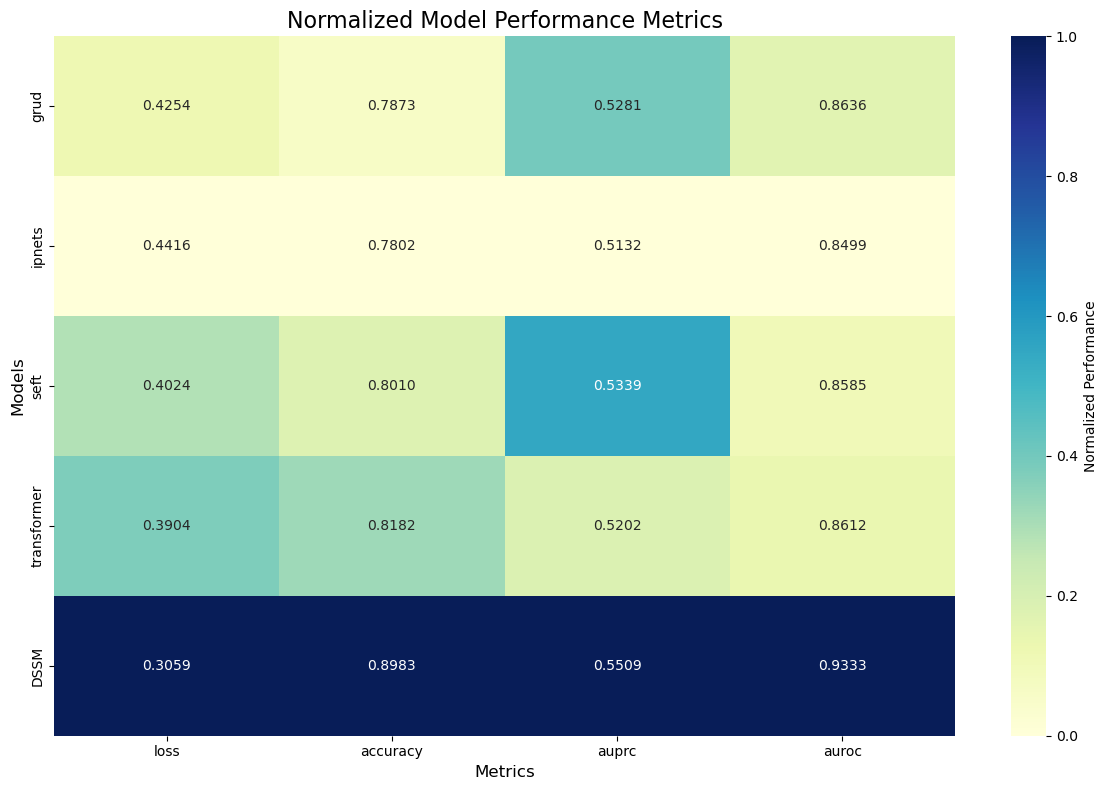

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
# Prepare the data
data = {
    'grud': {
        "loss": 0.4254, 
        "accuracy": 0.7873, 
        "auprc": 0.5281, 
        "auroc": 0.8636
    },
    'ipnets': {
        "loss": 0.4416, 
        "accuracy": 0.7802, 
        "auprc": 0.5132, 
        "auroc": 0.8499
    },
    'seft': {
        "loss": 0.4024, 
        "accuracy": 0.801, 
        "auprc": 0.5339, 
        "auroc": 0.8585
    },
    'transformer': {
        "loss": 0.3904, 
        "accuracy": 0.8182, 
        "auprc": 0.5202, 
        "auroc": 0.8612
    },
    'DSSM': {
       "loss": df['loss'][0],
        "accuracy": df['accuracy'][0],
        "auprc": df['auprc'][0],
        "auroc": df['auroc'][0],
    }
}

# Metrics where lower is better
lower_better = ['loss']

# Create DataFrame
df = pd.DataFrame(data).T

# Normalize the data
def normalize_data(df, lower_better_cols):
    normalized_df = df.copy()
    for col in df.columns:
        if col in lower_better_cols:
            # For lower better metrics, invert and min-max normalize
            col_min = df[col].min()
            col_max = df[col].max()
            normalized_df[col] = 1 - (df[col] - col_min) / (col_max - col_min)
        else:
            # For higher better metrics, do standard min-max normalization
            col_min = df[col].min()
            col_max = df[col].max()
            normalized_df[col] = (df[col] - col_min) / (col_max - col_min)
    return normalized_df

# Normalize data
normalized_df = normalize_data(df, lower_better)

# Set up the plot
plt.figure(figsize=(12, 8))
sns.heatmap(normalized_df, annot=df, cmap='YlGnBu', 
            fmt='.4f', cbar_kws={'label': 'Normalized Performance'})

plt.title('Normalized Model Performance Metrics', fontsize=16)
plt.ylabel('Models', fontsize=12)
plt.xlabel('Metrics', fontsize=12)
plt.tight_layout()
plt.show()